<a href="https://colab.research.google.com/github/kirmel4/MelSpectrogrammClassificationCNN/blob/main/MelSpectrogrammClassificationCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Применение Мел-Спектрограммы в задаче аккустической классификации звуков.
Исследование проводилось на примере датасета ESC-50. Из него были выбраны классы, относящиеся к человеческим звукам (без речи).

In [ ]:
import os
import torch
from torch.utils.data import Dataset
import pandas as pd
import torchaudio
import librosa
import numpy as np
import math
import random
import os
import pathlib
import requests
import shutil
from scipy.io import wavfile
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader, random_split
from librosa.util import buf_to_float
from librosa.display import waveshow, specshow
from librosa import amplitude_to_db, stft, power_to_db
from torch import nn
from torchsummary import summary
from librosa.core import fft_frequencies
from librosa.filters import mel
from sklearn.preprocessing import MinMaxScaler

SAMPLE_RATE = 16000
FFT = 512
HOP = 256
MELS = 11

ANNOTATIONS_FILE = "/content/ESC-50/meta/esc50_10labels.csv"
AUDIO_DIR = "/content/ESC-50/audio"

Загрузка аннотации к датасету с последующим отбором необходимых для задачи данных. (human & non-speech sounds относятся к 20-29 классам включительно)

In [ ]:
!git clone 'https://github.com/karolpiczak/ESC-50.git'

fatal: destination path 'ESC-50' already exists and is not an empty directory.


In [ ]:
metadata = pd.read_csv('/content/ESC-50/meta/esc50.csv')
metadata.drop(metadata[(metadata['target']>29) | (metadata['target'] < 20)].index, inplace = True)
metadata.to_csv(path_or_buf = '/content/ESC-50/meta/esc50_10labels.csv')

In [ ]:
metadata.shape

(400, 7)

#Аугментация и препроцессинг
Мы не будем подавать на вход модели отдельно оригинальные аудиофайлы и аугментированные, так как, увеличивая количество эпох, наша модель в любом случае хотя бы раз увидит неаугментированные файлы, к тому же, будет лучше, если будет большое разнообразие одних и тех же звуков. Конечно, аугментированные данные никогда не будут лучше новых данных, но в данной задаче мы ограничены размером датасета




In [ ]:
def get_sample(path, resample=16000):
  effects = [
      ['gain', '-n'],
    ["remix", "1"],
    ['rate', f'{resample}']
    ]
  waveform, sample_rate = torchaudio.sox_effects.apply_effects_file(path, effects=effects)
  return waveform, sample_rate  

Реализация кастомного датасета на основе ESC-50

In [ ]:
class ESC_50(Dataset):

    def __init__(self, annotations_file, audio_dir, transformation,
                 target_sample_rate):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = get_sample(audio_sample_path)
        signal = self._random_gain_(signal)
        #signal = _add_white_noise_(signal)
        signal = self.transformation(signal)
        return signal, label

    def _random_gain_(self, signal, min_factor=0.1, max_factor=0.12):
      gain_rate = random.uniform(min_factor, max_factor)
      augmented_signal = signal * gain_rate
      return augmented_signal
    
    def _add_white_noise_(self, signal, noise_percentage_factor = 0.1): #С помощью данной функции мы 1) нормализуем звук 3)делаем моно сигнал 2)проводим ресэмплинг от 44.1khZ к 16kHz для уменьшения вычислительной сложности
      noise = torch.randn(signal.shape)
      augmented_signal = signal + noise * (signal.std()**0.5) * noise_percentage_factor
      return augmented_signal

    def _get_audio_sample_path(self, index):
        fold = f"fold{self.annotations.iloc[index, 5]}"
        path = os.path.join(self.audio_dir, self.annotations.iloc[
            index, 0])
        return path

    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 2]

Берём преобразование в спектрограмму из класса MelSpectrogram

In [ ]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=FFT,
        hop_length=HOP,
        n_mels=MELS
    )

Инициализируем наш датасет и делим его на тренировочную, валидационную и тестовую выборки

In [ ]:
dataset = ESC_50(ANNOTATIONS_FILE, AUDIO_DIR, mel_spectrogram,
                            SAMPLE_RATE)
dataset_size = len(dataset)
dataset.annotations = dataset.annotations.iloc[:, 1:7]
dataset.annotations.iloc[:, 2] = dataset.annotations.iloc[:, 2] - 20 #теперь классы занумерованы от 0 до 9
# определяем пропорции выборок
train_split = 0.8
val_split = 0.1
test_split = 0.1
# считаем размер каждой выборки
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
# создаём дата лоадеры, которые делят наши данные на батчи
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
dataset.annotations.iloc[:5, 0:7]

,filename,fold,target,category,esc10,src_file
0,1-104089-A-22.wav,1,2,clapping,False,104089
1,1-104089-B-22.wav,1,2,clapping,False,104089
2,1-105224-A-22.wav,1,2,clapping,False,105224
3,1-110537-A-22.wav,1,2,clapping,False,110537
4,1-115920-A-22.wav,1,2,clapping,False,115920


In [ ]:
dataset[0][0].shape

torch.Size([1, 11, 313])

In [ ]:
len(dataset)

400

Функции для демонстрации осциллограммы и спектрограммы аудиофайлов

In [ ]:
import matplotlib.pyplot as plt

def _plot(waveform, sample_rate, title):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    if title == "Waveform":
      axes[c].plot(time_axis, waveform[c], linewidth=1)
      axes[c].grid(True)
    else:
      axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
  figure.suptitle(title)
  plt.show(block=False)

def plot_waveform(waveform, sample_rate):
  _plot(waveform, sample_rate, title="Waveform")

def plot_specgram(waveform, sample_rate):
  _plot(waveform, sample_rate, title="Spectrogram")

Функция для воспроизведения аудиофайлов

In [ ]:
from IPython.display import Audio, display
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

Пример аугментации аудиофайла

In [ ]:
example = '/content/ESC-50/audio/1-30709-C-23.wav'

In [ ]:
effects_ = [
      ['gain', '-n'],
    ["remix", "1"],
    ['rate', f'{SAMPLE_RATE}']
    ]
waveform, sample_rate_ = torchaudio.sox_effects.apply_effects_file(example, effects=effects_)

Хочется отметить что рандомное увеличение звука для аудио сложно продемонстрировать на примере и оно может быть не сильно заметно для человека, что нельзя сказать про модель

In [ ]:
def add_white_noise(signal, noise_percentage_factor = 0.1):
    noise = torch.randn(signal.shape)
    augmented_signal = signal + noise * (signal.std()**0.5) * noise_percentage_factor
    return augmented_signal

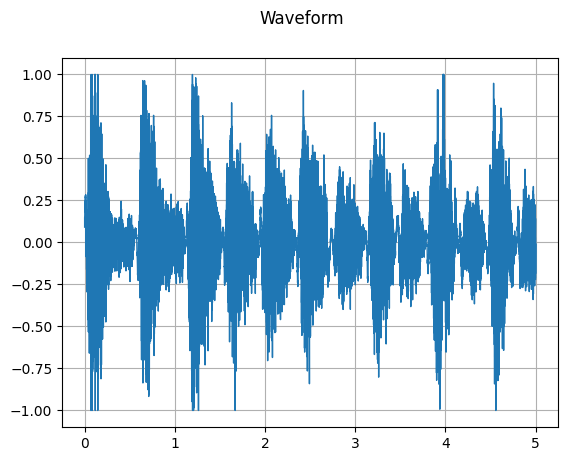

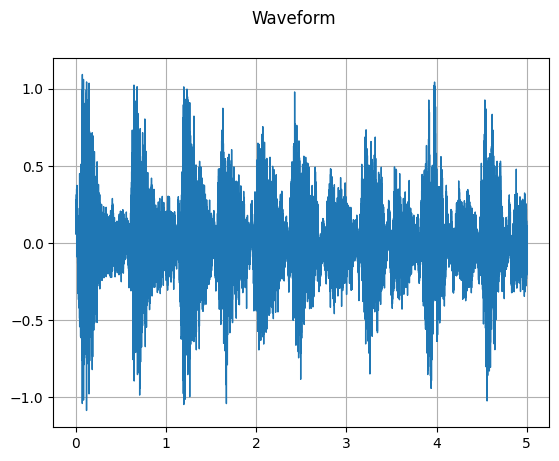

In [ ]:
plot_waveform(waveform, sample_rate_)
play_audio(waveform, sample_rate_)
plot_waveform(add_white_noise(waveform), sample_rate_)
play_audio(add_white_noise(waveform), sample_rate_)

В связи с тем, что человеческое ухо более чувствительно к изменениям низких частот, было введено понятие *мел*. Так как мы хотим приблизить предсказания модели к человеческим, то и данные нужно подавать такими, какими их слышит человек.
Фильтры, размещенные на частотной шкале, в свою очередь скалярно умножаются на каждый столбец исходной спектрограммы , после чего получается вектор чисел, по размеру равный количеству фильтров. 
А так же такое преобразование уменьшает размерность пространства признаков, следвательно, уменьшает количество обучаемых параметров для нейронной сети.

Выбор 11 мел-фильтров был обусловлен тем, что у нас не такие сложные данные и нам не совсем важно тонко чувствовать грань между разными частотами, как например в классификации музыкальных инструментов или спикера

Визуализация линейного размещения мел-фильтров на частотной оси и мел-оси

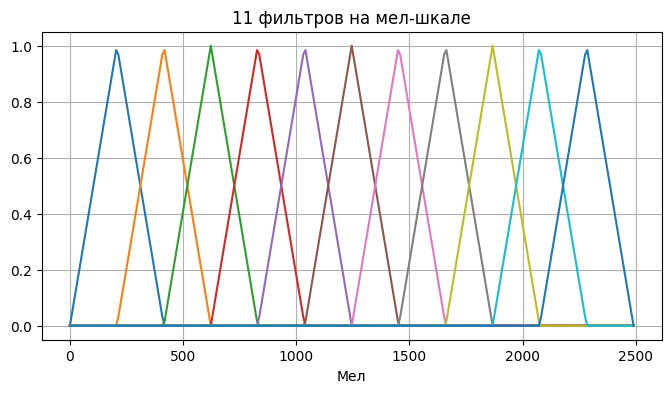

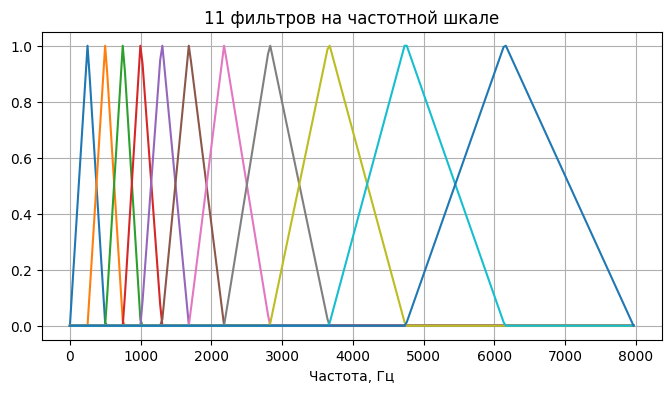

In [ ]:
# код был взят отсюда (https://librosa.github.io/librosa/_modules/librosa/filters.html#mel)
def freq_to_mel(f):
    return 1127.0 * np.log(1.0 + f / 700.0)
n_mels_demo = 11
max_mel = freq_to_mel(SAMPLE_RATE//2)
mel_f = np.linspace(0, SAMPLE_RATE//2, n_mels_demo + 2)

weights_ = np.zeros((n_mels_demo, int(1 + FFT // 2)))

fftfreqs = fft_frequencies(sr=SAMPLE_RATE, n_fft=FFT)
fdiff = np.diff(mel_f)
ramps = np.subtract.outer(mel_f, fftfreqs)

for i in range(n_mels_demo):
    # lower and upper slopes for all bins
    lower = -ramps[i] / fdiff[i]
    upper = ramps[i+2] / fdiff[i+1]

    # .. then intersect them with each other and zero
    weights_[i] = np.maximum(0, np.minimum(lower, upper))

# Рисуем полученные фильтры на мел шкале
plt.figure(figsize=(8, 4))
plt.title('{} фильтров на мел-шкале'.format(n_mels_demo))
for f in weights_:
    plt.plot(f)
plt.xlabel('Мел')
plt.grid()
freq_labels_ = [freq for freq in range(0, int(max_mel), 500)]
plt.xticks(ticks=np.linspace(0, FFT//2 + 1, len(freq_labels_)), labels=freq_labels_)
plt.show()

# Рисуем полученные фильтры на частотной шкале
mel_matrix = mel(sr=SAMPLE_RATE, n_fft=FFT, n_mels=MELS)
# делаем фильтры "высотой" единица
mel_matrix = MinMaxScaler().fit_transform(mel_matrix.T).T

plt.figure(figsize=(8, 4))
plt.title('{} фильтров на частотной шкале'.format(n_mels_demo))
for f in mel_matrix:
    plt.plot(f)
plt.grid()
plt.xlabel('Частота, Гц')
freq_labels_ = [freq for freq in range(0, SAMPLE_RATE//2 + 1, 1000)]
plt.xticks(ticks=np.linspace(0, FFT//2 + 1, len(freq_labels_)), labels=freq_labels_)
plt.show()

In [ ]:
def show_spec(f_name):
    sr, wav_data = wavfile.read(f_name)
    wav_data = buf_to_float(wav_data)
    spec = stft(wav_data, n_fft=FFT)
    spec_db = amplitude_to_db(abs(spec))
    return spec
spec_ = show_spec(example)

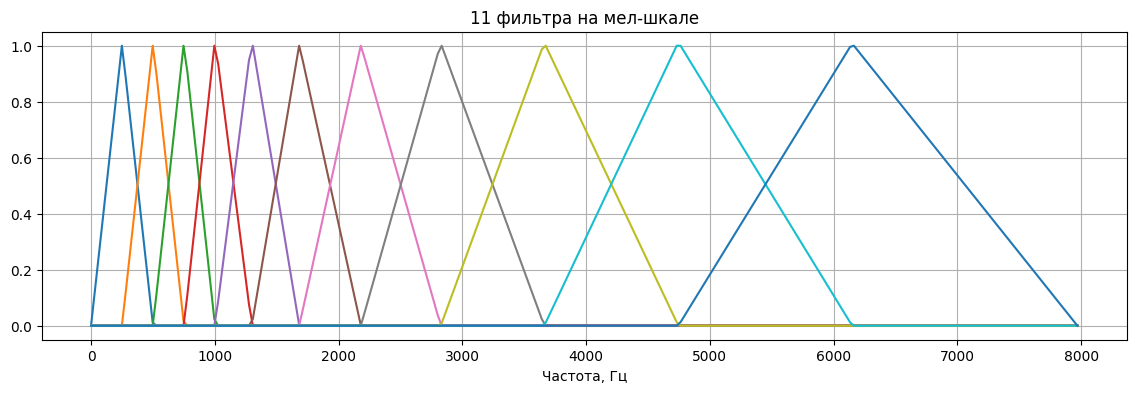

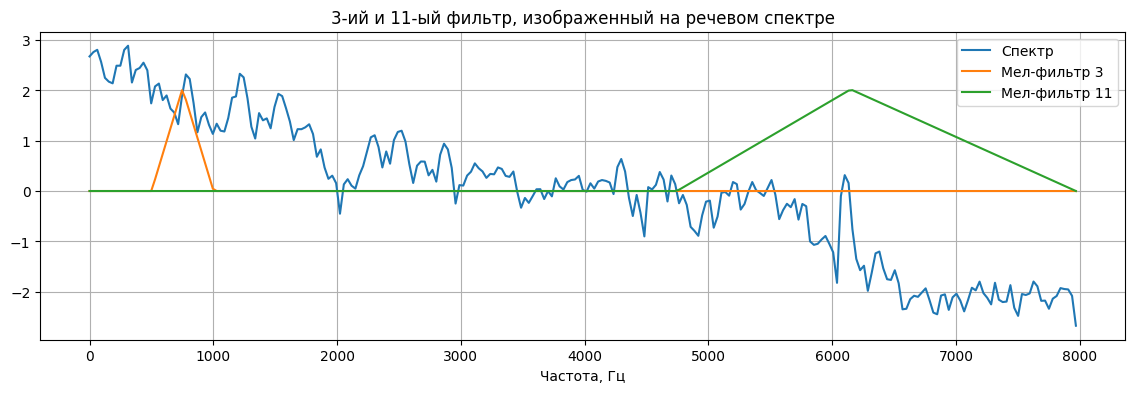

In [ ]:
mel_matrix_ = mel(sr=SAMPLE_RATE, n_fft=FFT, n_mels=MELS)
mel_matrix__ = MinMaxScaler().fit_transform(mel_matrix.T).T

# Рисуем полученные фильтры на частотной шкале
plt.figure(figsize=(14, 4))
plt.title('{} фильтра на мел-шкале'.format(MELS))
for f in mel_matrix__:
    plt.plot(f)
plt.grid()
plt.xlabel('Частота, Гц')
freq_labels = [freq for freq in range(0, SAMPLE_RATE//2 + 1, 1000)]
plt.xticks(ticks=np.linspace(0, FFT//2 + 1, len(freq_labels_)), labels=freq_labels_)
plt.show()

# отдельный фильтр вместе со спектром
third_filter = mel_matrix__[2]
eleventh_filter = mel_matrix__[10]
spec_part = np.log10(np.abs(spec_[:, 100]))
spec_part -= spec_part.mean()

plt.figure(figsize=(14, 4))
plt.plot(spec_part, label='Спектр')
plt.title('3-ий и 11-ый фильтр, изображенный на речевом спектре')
plt.plot(third_filter*2, label='Мел-фильтр 3')
plt.plot(eleventh_filter*2, label='Мел-фильтр 11')
plt.legend()
plt.grid()
plt.xlabel('Частота, Гц')
freq_labels_ = [freq for freq in range(0, SAMPLE_RATE//2 + 1, 1000)]
plt.xticks(ticks=np.linspace(0, FFT//2 + 1, len(freq_labels_)), labels=freq_labels_)

plt.show()

In [ ]:
print('Форма матрицы фильтров:', mel_matrix.shape)
print('Форма спектрограммы:', spec_.shape)

mel_spec_ = np.dot(mel_matrix_, spec_) #матричное произведение

print('Форма мел-спектрограммы:', mel_spec_.shape)

Форма матрицы фильтров: (11, 257)
Форма спектрограммы: (257, 1723)
Форма мел-спектрограммы: (11, 1723)


Как мы можем заметить, такое преобразование убрало "лишнюю" информацию и оставило "суть" данных. 

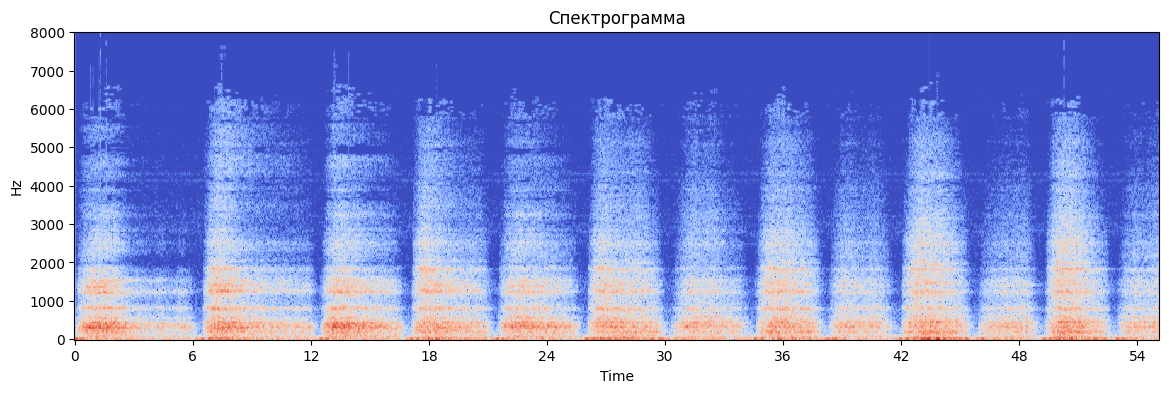

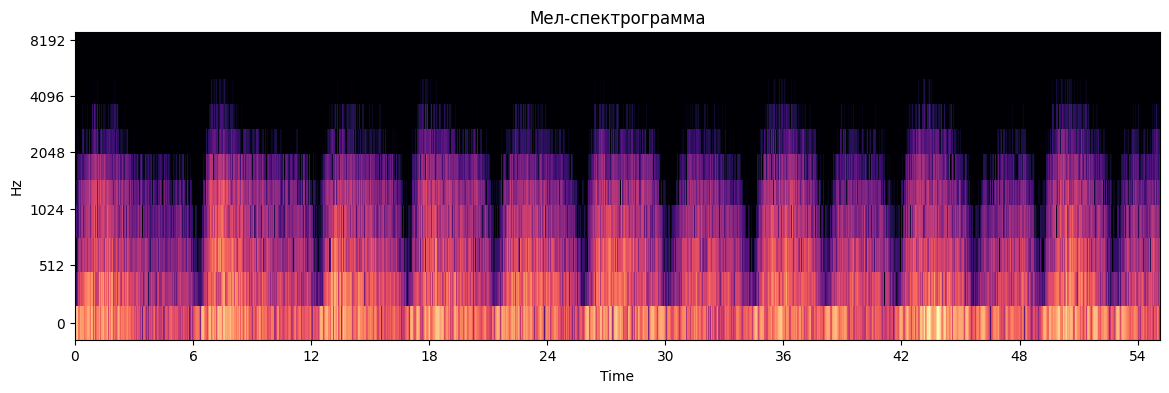

In [ ]:
spec_db = amplitude_to_db(abs(spec_))
plt.figure(figsize=(14, 4))
specshow(spec_db, sr=SAMPLE_RATE, x_axis='time', y_axis='hz')
plt.title('Спектрограмма')
plt.show()

mel_spec_db = amplitude_to_db(abs(mel_spec_))
plt.figure(figsize=(14, 4))
plt.title('Мел-спектрограмма')
specshow(mel_spec_db, sr=SAMPLE_RATE, x_axis='time', y_axis='mel')
plt.show()

#Cвёрточная нейронная сеть

Рассмотрим Свёрточную нейронную сеть, так как именно этот вид сетей показывает наилучшие результаты в области распознавания изображений
Собственно для этого мы и делали такие преобразования сначала в спектрограмму, а затем в мел-спектрограмму. Важной особенностью
свёрточных нейронных сетей является устойчивость к изменениям масштаба и смещениям
изображения, что, очевидно, имеет место в случае спектрограмм речевых сигналов

Рассмотрим архитектуру нейронной сети:

1) Сверточные слои, выделяющие из черно-белой картинки сначала 16 признаков, затем из 16 - > 32 и так далее с ядром 3x3,  функцией активации ReLU и слоем подвыборки (MaxPooling) с ядром 2×2

2) Слой преобразования массива в вектор

3) Слой Dropout против переобучения

4) Полносвязный слой из 10 нейронов; активационная функция «сигмоида»



In [ ]:
class CNNNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        # 4 conv blocks / flatten / linear / softmax
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(5376, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        logits = self.linear(x)
        predictions = self.softmax(logits)
        return predictions

In [ ]:
cnn = CNNNetwork()
summary(cnn.cuda(), (1, 11, 313))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 13, 315]             160
              ReLU-2          [-1, 16, 13, 315]               0
         MaxPool2d-3           [-1, 16, 6, 157]               0
            Conv2d-4           [-1, 32, 8, 159]           4,640
              ReLU-5           [-1, 32, 8, 159]               0
         MaxPool2d-6            [-1, 32, 4, 79]               0
            Conv2d-7            [-1, 64, 6, 81]          18,496
              ReLU-8            [-1, 64, 6, 81]               0
         MaxPool2d-9            [-1, 64, 3, 40]               0
           Conv2d-10           [-1, 128, 5, 42]          73,856
             ReLU-11           [-1, 128, 5, 42]               0
        MaxPool2d-12           [-1, 128, 2, 21]               0
          Flatten-13                 [-1, 5376]               0
           Linear-14                   

In [ ]:
BATCH_SIZE = 128
EPOCHS = 100
LEARNING_RATE = 0.001

Обычная функция для тренировки одной эпохи с валидацией и подсчётом лосса (в нашем случае функция ошибки - Кросс-Энтропия) и accuracy

In [ ]:
def train_single_epoch(model, train_dataloader, validation_dataloader, loss_fn, optimiser, device):
    running_loss = 0.0 
    correct = 0 
    total = 0 
    running_val_loss = 0.0
    val_correct = 0
    val_total = 0
    model.train()
    for input, target in train_dataloader:
        input, target = input.to(device), target.to(device)
        prediction = model(input)
        loss = loss_fn(prediction, target)
        # backpropagate error and update weights
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        running_loss += loss.item() 
        _, predicted = prediction.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
    valid_loss = 0.0  
    for input, target in val_loader:
        if torch.cuda.is_available():
            input, target = input.cuda(), target.cuda()
        prediction = model(input)
        loss = loss_fn(prediction,target)
        running_val_loss += loss.item() 
        _, predicted = prediction.max(1)
        val_total += target.size(0) 
        val_correct += predicted.eq(target).sum().item()

    avg_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / total
    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100. * val_correct / val_total
    print(f"loss: {avg_loss:.4f}"  +'|' + f"val_loss: {avg_val_loss:.4f}""" )
    print(f"accuracy: {accuracy}" +  '|' + f"val_accuracy: {val_accuracy}""")

Вводим функцию ошибки 

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(cnn.parameters(),
                                 lr=LEARNING_RATE)

Фукнция, реализующая всё обучение

In [ ]:
def train(model, train_loader, validation_dataloader, loss_fn, optimiser, device, epochs):
    for i in range(epochs):
      print(f"Epoch {i+1}")
      train_single_epoch(model, train_loader, val_loader, loss_fn, optimiser, device)
      print("---------------------------")
    print("Finished training")

In [ ]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using {device}")

Using cuda


In [ ]:
cnn = CNNNetwork().to(device)
print(cnn)

CNNNetwork(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=5376, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(cnn.parameters(),
                                 lr=LEARNING_RATE)

In [ ]:
# train model
train(cnn, train_loader, val_loader, loss_fn, optimiser, device, EPOCHS)

Epoch 1
loss: 2.2734|val_loss: 2.2153
accuracy: 12.75|val_accuracy: 21.25
---------------------------
Epoch 2
loss: 2.1753|val_loss: 2.1032
accuracy: 28.75|val_accuracy: 35.25
---------------------------
Epoch 3
loss: 2.0887|val_loss: 2.0329
accuracy: 39.5|val_accuracy: 46.0
---------------------------
Epoch 4
loss: 2.0473|val_loss: 2.0576
accuracy: 42.0|val_accuracy: 40.75
---------------------------
Epoch 5
loss: 2.1054|val_loss: 2.0755
accuracy: 35.75|val_accuracy: 38.0
---------------------------
Epoch 6
loss: 2.0454|val_loss: 2.0280
accuracy: 41.0|val_accuracy: 43.25
---------------------------
Epoch 7
loss: 2.0234|val_loss: 2.0053
accuracy: 43.25|val_accuracy: 45.5
---------------------------
Epoch 8
loss: 2.0191|val_loss: 2.0137
accuracy: 44.5|val_accuracy: 44.25
---------------------------
Epoch 9
loss: 2.0525|val_loss: 2.0784
accuracy: 41.75|val_accuracy: 37.75
---------------------------
Epoch 10
loss: 2.0747|val_loss: 2.0188
accuracy: 38.5|val_accuracy: 44.5
----------------

#Оценка модели

In [ ]:
# сохраняем модель
torch.save(cnn.state_dict(), "CNNforESC_50.pth")
print("Trained CNNforESC_50 saved at CNNforESC_50.pth")

Trained CNNforESC_50 saved at CNNforESC_50.pth


In [ ]:
def evaluate(model, test_dataloader, criterion): 
  model.eval() 
  total_loss = 0 
  correct = 0
  model = model.to('cuda')
  with torch.no_grad():     
    for data, target in test_loader:
      if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()         
      output = model(data)        
      total_loss += criterion(output, target).item()         
      pred = output.argmax(dim=1, keepdim=True)         
      correct += pred.eq(target.view_as(pred)).sum().item()  
    avg_loss = total_loss / len(test_loader.dataset) 
    accuracy = 100. * correct / len(test_loader.dataset)  
  print(f'Test set: Average loss: {avg_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

In [ ]:
evaluate(cnn, test_loader, loss_fn)

Test set: Average loss: 0.0541, Accuracy: 317/400 (79.25%)


На валидации получили максимальную точность 80. А на тестовой выборке - 

Получилось так, что аугментация рандомный усилением или ослаблением звука оказалась лучше, чем добавление шума. Так что тренировал только с одним типом. Так же прирост метрики дало уменьшение частоты дискретизации, увеличение размера батча и количества эпох. А самый большой прирост дало уменьшение мел-фильтров.

Предполагаю, что результаты можно улучшить, используя мел кепстральные коэффициенты, взять больше данных и провести более сложную, но качественную аугментацию

In [ ]:
class_mapping = [
    "crying_baby",
    "sneezing",
    "clapping",
    "breathing",
    "coughing",
    "footsteps",
    "laughing",
    "brushing",
    "snoring",
    "drinking"
]

In [ ]:
def predict(model, input, target, class_mapping):
    model.eval()
    with torch.no_grad():
        input = input.cuda()
        predictions = model(input)
        # Tensor (1, 10) -> [ [0.1, 0.01, ..., 0.6] ]
        predicted_index = predictions[0].argmax(0)
        predicted = class_mapping[predicted_index]
        expected = class_mapping[target]
    return predicted, expected


In [ ]:
from random import randint
r = randint(0,len(dataset))   
input, target = dataset[r][0], dataset[r][1]
input.unsqueeze_(0)

    # make an inference
predicted, expected = predict(cnn, input, target,
                                  class_mapping)
print(f"Predicted: '{predicted}', expected: '{expected}'")

Predicted: 'drinking', expected: 'drinking'
